In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from aeon.utils.numba.general import z_normalise_series_2d

# from aeon.distances import euclidean_distance
# from aeon.distances import dtw_distance
from aeon.distances import get_distance_function

In [2]:
%load_ext autoreload
%autoreload 2

from ksfdtw.distance_measures import psdtw_prime_cache_dict as psdtw_prime
from ksfdtw.utils import precision_at_k

In [3]:
# A neat way to load the dataset, but more complicated to use
# data = np.load("../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz")
# data_dict = {key: data[key] for key in data.files}

# A old way to load the dataset
data = np.load(
    "../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz",
    allow_pickle=True,
)
X_train_scaled = data["X_train_scaled"]
X_train_proc = data["X_train_proc"]
X_train_proc_noise = data["X_train_proc_noise"]
y_train = data["y_train"]
X_test_scaled = data["X_test_scaled"]
X_test_proc = data["X_test_proc"]
X_test_proc_noisy = data["X_test_proc_noise"]
y_test = data["y_test"]
train_cutting_orig = data["train_cutting_orig"].tolist()
train_cutting_final = data["train_cutting_final"].tolist()
test_cutting_orig = data["test_cutting_orig"].tolist()
test_cutting_final = data["test_cutting_final"].tolist()

In [4]:
X_train_scaled.shape, X_train_proc.shape, X_train_proc_noise.shape

((50, 150), (50, 150), (50, 150))

In [5]:
# X_train_scaled = X_train_scaled.squeeze()
X_train_scaled = X_train_scaled

In [6]:
X_train_scaled.shape

(50, 150)

In [7]:
X_train_scaled_norm = z_normalise_series_2d(X_train_scaled)
X_train_proc_norm = z_normalise_series_2d(X_train_proc)
X_train_proc_noise_norm = z_normalise_series_2d(X_train_proc_noise)

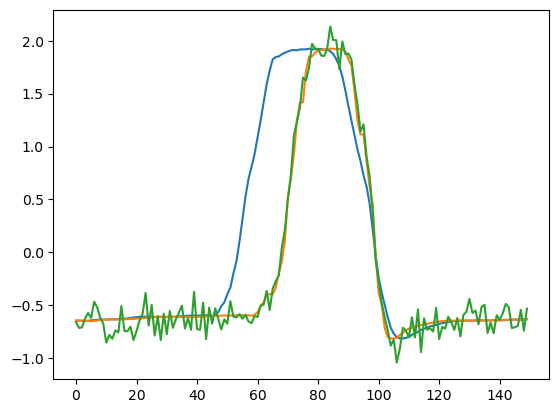

In [8]:
plt.plot(X_train_scaled[1])
plt.plot(X_train_proc[1])
plt.plot(X_train_proc_noise[1])

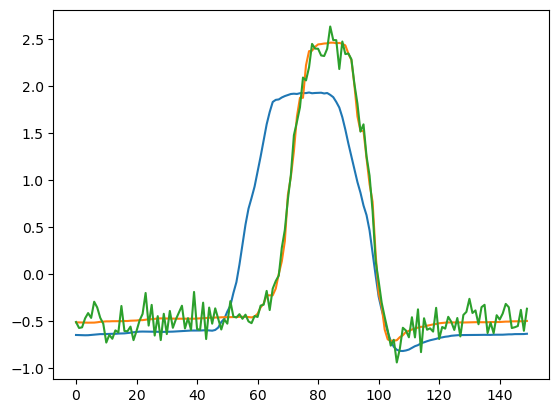

In [9]:
plt.plot(X_train_scaled_norm[1])
plt.plot(X_train_proc_norm[1])
plt.plot(X_train_proc_noise_norm[1])

In [10]:
query_set = X_train_proc_noise_norm[:7]
# query_set = X_train_proc_norm
# target_set = X_train_scaled
target_set = X_train_scaled_norm[:7]
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

In [11]:
# Q = query_set[0]
# C = target_set[0]
# psdtw_prime(Q, C, l=2, P=3, r=0.1)

# Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [12]:
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
# **aeon**
# *dtw*
dist_func_prime = get_distance_function("dtw")
dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *shape_dtw*
# dist_func_prime = get_distance_function("shape_dtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *ddtw*
# dist_func_prime = get_distance_function("ddtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *wdtw*
# dist_func_prime = get_distance_function("wdtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *wddtw*
# dist_func_prime = get_distance_function("wddtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *adtw*
# dist_func_prime = get_distance_function("adtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *erp*
# dist_func_prime = get_distance_function("erp")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *edr*
# dist_func_prime = get_distance_function("edr")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *msm*
# dist_func_prime = get_distance_function("msm")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *twe*
# dist_func_prime = get_distance_function("twe")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *lcss*
# dist_func_prime = get_distance_function("lcss")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *euclidean*
# dist_func = get_distance_function("euclidean")

# *manhattan*
# dist_func = get_distance_function("manhattan")

# *minkowski*
# dist_func = get_distance_function("minkowski")

# *sbd*
# dist_func = get_distance_function("sbd")

In [13]:
# **ksfdtw**
# *psed*
# dist_func = lambda Q, C: psdtw_prime(Q, C, l=2, P=3, r=0.1, dist_method=0)
# *psdtw*
# dist_func = lambda Q, C: psdtw_prime(Q, C, l=2, P=3, r=0.1, dist_method=1)

In [ ]:
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    distances = np.array([dist_func(query_set[i], x) for x in target_set])
    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
# print(precision_at_1, precision_at_3, precision_at_5, precision_at_7)
print(
    f"{precision_at_1 / len(query_set):.2f},",
    f"{precision_at_3 / len(query_set):.2f},",
    f"{precision_at_5 / len(query_set):.2f},",
    f"{precision_at_7 / len(query_set):.2f}",
)

# psdtw 0.29, 0.71, 1.00, 1.00
# psed 0.29, 1.00, 1.00, 1.00

0.29, 0.71, 0.86, 1.00


In [16]:
num_queries = len(query_set)
row = {
    "precision_at_1": precision_at_1 / num_queries,
    "precision_at_3": precision_at_3 / num_queries,
    "precision_at_5": precision_at_5 / num_queries,
    "precision_at_7": precision_at_7 / num_queries,
}

In [ ]:
# os.makedirs("results", exist_ok=True)\
csv_path = "../results/psdtw_result_temp.csv"
pd.DataFrame([row]).to_csv(
    csv_path,
    mode="a",
    index=False,
    header=not os.path.exists(csv_path),
)
print(f"Saved to {csv_path}")

Saved to ../results/psdtw_temp.csv


In [15]:
import datetime

print(f"This notebook was last run end-to-end on: {datetime.datetime.now()}\n")
###
###
###

This notebook was last run end-to-end on: 2025-09-04 19:37:31.867712

